In [73]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from parameters import read_params

from scipy.special import gamma
def myGamma(zeta):
    return gamma(1-1/zeta)

DIR = r"/home/cz/Dropbox/Summer RA Model EP/Parameters/"

def pv(name, mat):
    print("{}: {}".format(name.rjust(10), mat.shape))

In [74]:
param = read_params()

Found 13 parameters
param.beta = 0.28818
param.q = 0.67565
param.mu = 3.4112
param.zeta = 1.62
param.alpha = 0.05
param.sigma = 4
param.psi = 0.76551
param.delta = 0.91803
param.eta = 0.35
param.gamma = 0.35055
param.nu = 0.0187
param.kappa = 0.42
param.r = 2.8866

 skill1880: (645, 2)
  wage1880: (645, 2)
       Q_A: (645, 5)
      Q_NA: (645, 5)
         Z: (5, 2)
        vA: (5, 1)
   Capital: (5, 1)
       phi: (4, 1)
       tau: (645, 645)
 amenities: (645, 5)


## Define constants

In [75]:
def psi(r):
    n = param.eta
    ret = 1 + (param.beta**(1/(1-n))) * ((1+r)**(n/(1-n)))
    return 1/ret

$$
r = R - \delta
$$

In [76]:
psi(param.r)

0.7655096595807223

In [77]:
myGamma(param.zeta)

2.3211529336709016

In [78]:
R = 3.63

## Mess with the variables a bit

In [79]:
# now this is just for the short names
skills, wages = param.skill1880, param.wage1880
Q_A, Q_NA = param.Q_A, param.Q_NA

Z, vA, Capital, phi = param.Z, param.vA, param.Capital, param.phi

tau, amenities = param.tau, param.amenities

In [80]:
# TODO MAKE 4 DIMENSIONS (time, skill, sector, region)

skills = np.expand_dims(skills, 2).transpose((2,1,0))
pv("skills", skills)

wages = np.expand_dims(wages, 2).transpose((2,1,0))
pv("wages", wages)

Q = np.stack((Q_A, Q_NA), axis=1).transpose((2,1,0))
pv("Q", Q)

vA = vA.flatten()
vAt= np.array([vA[1], 1-vA[1]]).reshape(2,1)
pv("vAt", vAt)

Capital = Capital.flatten()
pv("Capital", Capital)

pv("tau", tau)

amenities = amenities.transpose((1,0))
pv("amenities", amenities)

    skills: (1, 2, 645)
     wages: (1, 2, 645)
         Q: (5, 2, 645)
       vAt: (2, 1)
   Capital: (5,)
       tau: (645, 645)
 amenities: (5, 645)


In [81]:
# define some constants for indexing
t = 0
A, NA = 0,1
L, H = 0,1
R,S,T = 2,1,0

# Remember that Psi is indexed like Psi[L,A]
Psi = np.array([[1,1],
                [param.q, param.mu * param.q]])

# Define methods

In [82]:
# useful for resets
def readWages():
    wages = param.wage1880
    wages = np.expand_dims(wages, 2).transpose((2,1,0))
    wages = wages / np.sum(wages) # what if we normalize for fun
    return wages

def readSkills():
    skills = param.skill1880
    skills = np.expand_dims(skills, 2).transpose((2,1,0))
    return skills

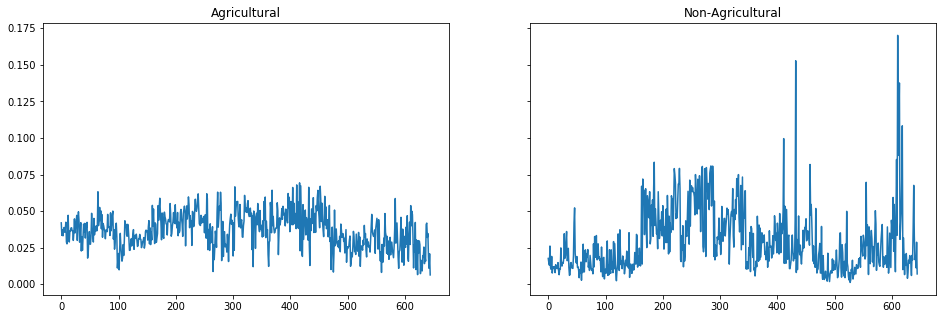

In [372]:
# useful for plotting
plot_params = {
    'alpha': 0.4,
    's': 4
}

def drawLog(wages):
    plt.scatter(np.log(wages[t,A]), np.log(wages[t,NA]),
           **plot_params)

def draw(wages):
    plt.scatter(wages[t,A], wages[t,NA],
           **plot_params)

def plotANA(x):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16,5))
    
    ax1.plot(x[t,A])
    ax1.set_title("Agricultural")
    
    ax2.plot(x[t,NA])
    ax2.set_title("Non-Agricultural")
    
plotANA(wages)

In [83]:
def computePi(wages):
    """
    Parameters:
        wages - shape [time, Sectors, Regions]
        Q - shape [time, Sectors, Regions]
    
    Returns:
        pi has shape (1, 2, 645)
    """
    # Q is already raised**(sigma - 1)
    pi = Q[t] * wages**((1-param.alpha)*(1-param.sigma))
    
    # sum across regions
    normalize = np.sum(pi, axis=R)
    
    # normalize has shape (1,2), so we make it have shape (1,2,1)
    normalize = np.expand_dims(normalize, 2)
    pi = pi / normalize
    
    return pi

pi = computePi(wages)
np.sum(pi, axis=R)

array([[1., 1.]])

In [84]:
def computeTheta(wages):
    """
    196 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs)
    """
    Theta = np.matmul(Psi, wages**(param.zeta)) ** (1/param.zeta)
    Theta_l = Theta[0,L]
    Theta_h = Theta[0,H]
    return Theta_h, Theta_l

def computeTheta2(wages):
    """
    304 µs ± 2.88 µs per loop (mean ± std. dev. of 7 runs,
    """
    z = param.zeta
    Theta_h = (Psi[H,A]*(wages[t,A]**z) + Psi[H,NA]*(wages[t,NA]**z))**(1/z)
    Theta_l = (Psi[L,A]*(wages[t,A]**z) + Psi[L,NA]*(wages[t,NA]**z))**(1/z)
    return Theta_h, Theta_l

a,b = computeTheta(wages)
c,d = computeTheta2(wages)

np.sum(a-c), np.sum(b-d) # these are the same

(0.0, 0.0)

In [85]:
def computeLrt(skills):
    """
    Expects:
        skills[1,2,645]
        skills[0, L, :] == low-skilled populations across regions
    
    Returns:
        const_lambda - Lambda, 1-Lambda. This is constant throughout time
        totals - L. (portion of population in each region)
        skill_shares - share of high/low skill in each region. lambda_rt and 1-lambda_rt
        
    """
    const_lamda = np.sum(skills, axis=R)
    sums = np.sum(skills, axis=S)
    skill_shares = (skills/sums)
    return const_lamda, sums, skill_shares

def test_computeLrt(skills):
    const_lamda, sums, skill_shares = computeLrt(skills)

    print(const_lamda)
    print('L_rt sums to', np.sum(sums))
    
    x = np.sum(skill_shares, axis=S)
    print(np.allclose(x, np.ones_like(x)))
    
test_computeLrt(skills)

[[0.7046579  0.29534209]]
L_rt sums to 0.999999993419246
True


The majorit of commuting zones had agricultural employment shares exceeding 75% in 1880...

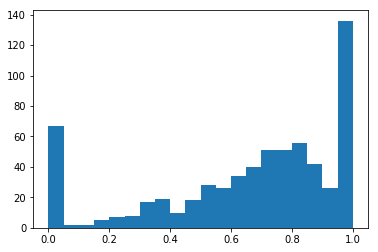

In [86]:
const_lamda, sums, skill_shares = computeLrt(skills)

plt.hist(skill_shares[t,A], bins=20)
plt.show()

In [87]:
np.sum(skills)

0.9999999934192461

In [88]:
skills, wages = readSkills(), readWages()

def computeGDP(skills, wages):
    """
    GDP is an actual number!
    """
    Theta_h, Theta_l = computeTheta(wages)
    
    constant= 1/(1-param.alpha) * myGamma(param.zeta)
    GDP = constant * np.sum((skills[t,H] * Theta_h + skills[t,L] * Theta_l))
    
    return GDP

computeGDP(skills, wages)

0.0034030779422166675

## Sectoral prices (and normalizing wages)

In [89]:
param.Z

array([[0.045844, 0.051099],
       [0.067368, 0.084494],
       [0.098668, 0.15938 ],
       [0.083907, 0.27512 ],
       [0.11267 , 0.48463 ]])

In [90]:
R_t = 3.63

In [91]:
Zt = param.Z[t]
Zt.shape

sector = NA

temp = Q[t,sector,0] * ((1/Zt[sector] * (wages[t,sector,0] / (1-param.alpha))**(1-param.alpha)* (R_t/param.alpha)**param.alpha))**(1-param.sigma)
temp

5.881977582807274

In [92]:
x = Q[t].transpose((1,0)) * (1/Zt * (wages[t].transpose((1,0)) / (1-param.alpha))**(1-param.alpha)* (R_t/param.alpha)**param.alpha)**(1-param.sigma)
x = x.transpose((1,0))
x.shape

x[sector, 0]

5.881977582807274

In [93]:
prices = np.sum(x, axis=1)**(1/(1-param.sigma))
prices # P_A, P_NA

array([0.02388413, 0.04312021])

In [94]:
# and then we normalize it
normprices = prices/prices[0]
normprices

array([1.        , 1.80539147])

What price normalization means for wages:
$$
P_{At} = \Big(\sum_j \Big( stuff \cdot \big(\frac{w_{Ajt}}{1-\alpha}\big)^{1-\alpha} \Big)^{1-\sigma} \Big)^{\frac{1}{1-\sigma}}
$$

$$
1 = \Big(\sum_j \Big( stuff \cdot \big(\frac{w_{Ajt}}{1-\alpha}\big)^{1-\alpha} \cdot P_{At}^{-1} \Big)^{1-\sigma} \Big)^{\frac{1}{1-\sigma}}
$$

$$
1 = \Big(\sum_j \Big( stuff \cdot \big(\frac{ w_{Ajt} \cdot P_{At}^{-\frac{1}{1-\alpha}}}{1-\alpha}\big)^{1-\alpha} \Big)^{1-\sigma} \Big)^{\frac{1}{1-\sigma}}
$$

Or equivalently:
$$
w_{new} = \frac{ w_{old}}{ P_{At}^{\frac{1}{1-\alpha}}}
$$

In [95]:
normwages = wages/(prices[0]**(1/(1-param.alpha)))
normwages

array([[[0.0299579 , 0.03178196, 0.03611341, ..., 0.06841253,
         0.10130349, 0.08424844],
        [0.01173056, 0.01164318, 0.00952227, ..., 0.0524142 ,
         0.08129671, 0.04365236]]])

In [96]:
# just be careful: if we do it this way, the wages will be great!
np.sum(normwages, axis=R)

array([[31.83960945, 19.12317556]])

In [149]:
def priceNormalize(wages):
    """
    Sets the price of the agricultural good to 1
    
    Parameters:
        Q_rst
        Z_st
        param.alpha
        R_t
        
    Returns:
        normalized wages
    """
    Zt = param.Z[t]
    x = Q[t].transpose((1,0)) * (1/Zt * (wages[t].transpose((1,0)) / (1-param.alpha))**(1-param.alpha)* (R_t/param.alpha)**param.alpha)**(1-param.sigma)
    x = x.transpose((1,0))
    prices = np.sum(x, axis=1)**(1/(1-param.sigma))
    normprices = prices/prices[0]

    wages = wages/(prices[0]**(1/(1-param.alpha)))
    return wages

In [146]:
wages = readWages()
for i in range(10):
    wages = priceNormalize(wages)
    print(wages[t,NA,:5])

[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]


## Part 1: Testing the wage loop

In [97]:
vAt, vAt.shape

(array([[0.32289],
        [0.67711]]), (2, 1))

In [236]:
wages = readWages()

lr = 0.03

# these are fixed
const_lamda, sums, skill_shares = computeLrt(skills)

previous_newWages = wages
for i in range(300):
    # normalize wages BY THE PRICE OF THE AGRICULTURAL GOOD

    wages = priceNormalize(wages)

    # compute the update
    pi = computePi(wages) # (1 by 2 by 645)
    Theta_h, Theta_l = computeTheta(wages) # (645,)
    GDP = computeGDP(skills, wages)
    revenue = (1-param.alpha) * pi * vAt * GDP
    GDP

    #  labor market clearing conditions

    # A
    s_hA = Psi[H,A] * (wages[t,A] / Theta_h)**(param.zeta)
    s_lA = Psi[L,A] * (wages[t,A] / Theta_l)**(param.zeta)
    x_A = myGamma(param.zeta) * (skills[t,H] * s_hA + skills[t,L] * s_lA)

    # NA
    s_hNA = Psi[H,NA] * (wages[t,NA] / Theta_h)**(param.zeta)
    s_lNA = Psi[L,NA] * (wages[t,NA] / Theta_l)**(param.zeta)
    x_NA = myGamma(param.zeta) * (skills[t,H] * s_hNA + skills[t,L] * s_lNA)

    newWages = revenue / np.vstack([x_A, x_NA])
    if i%20==0:
        print(i, np.sum(newWages), np.sum(wages))    

    loss = np.sum(np.abs(newWages - previous_newWages))
    previous_newWages = newWages
    
    wages = lr * newWages + (1-lr) * wages

    if loss < 1e-7:
        print('w-- #{}: {}'.format(i, loss))
        break

    if i%20 == 0:
        print(i, np.sum(newWages), np.sum(wages), loss)

0 603.9040904170906 50.96278500901588
0 603.9040904170906 67.55102417125812 602.9204867657702
20 54.16971006852264 44.258306617371375
20 54.16971006852264 44.55564872090591 0.23149506801949932
40 54.53158727827898 39.94334580930715
40 54.53158727827898 40.3809930533763 0.03501491916197461
60 54.382368671312896 38.21727056360873
60 54.382368671312896 38.70222350683985 0.01599084878148745
80 54.221261908729474 37.52486089819875
80 54.221261908729474 38.02575292851468 0.006701200448170579
100 54.15381631957041 37.24353465168664
100 54.15381631957041 37.75084310172315 0.0047785363090090596
120 54.15068689658327 37.14487982932293
120 54.15068689658327 37.65505404134074 0.0012900006802713329
140 54.14254150114969 37.11197517493255
140 54.14254150114969 37.62289216471906 0.0005625175835280679
160 54.15694107678982 37.10353244536518
160 54.15694107678982 37.61513470430792 0.000750081267701081
180 54.16257036809478 37.10378118713872
180 54.16257036809478 37.615544862567404 8.527014802715968e-05

In [341]:
def loopy(skills, wages, log=True):
    
    lr = 0.03

    # these are fixed
    const_lamda, sums, skill_shares = computeLrt(skills)

    previous_newWages = wages
    for i in range(300):
        # normalize wages BY THE PRICE OF THE AGRICULTURAL GOOD

        wages = priceNormalize(wages)

        # compute the update
        pi = computePi(wages) # (1 by 2 by 645)
        Theta_h, Theta_l = computeTheta(wages) # (645,)
        GDP = computeGDP(skills, wages)
        revenue = (1-param.alpha) * pi * vAt * GDP
        GDP

        #  labor market clearing conditions

        # A
        s_hA = Psi[H,A] * (wages[t,A] / Theta_h)**(param.zeta)
        s_lA = Psi[L,A] * (wages[t,A] / Theta_l)**(param.zeta)
        x_A = myGamma(param.zeta) * (skills[t,H] * s_hA + skills[t,L] * s_lA)

        # NA
        s_hNA = Psi[H,NA] * (wages[t,NA] / Theta_h)**(param.zeta)
        s_lNA = Psi[L,NA] * (wages[t,NA] / Theta_l)**(param.zeta)
        x_NA = myGamma(param.zeta) * (skills[t,H] * s_hNA + skills[t,L] * s_lNA)

        newWages = revenue / np.vstack([x_A, x_NA])

        loss = np.sum((newWages - previous_newWages)**2)
        previous_newWages = newWages

        wages = lr * newWages + (1-lr) * wages

        if loss < 1e-7:
            if log:
                print('w-- #{}: {}'.format(i, loss))
            break

        if i%20 == 0 and log:
            print('w-- #{}: {}'.format(i, loss))
            # print(i, np.sum(newWages), np.sum(wages), loss)
    
    return wages

In [375]:
wages = readWages()
newWages = loopy(skills, wages)

w-- #0: 68330.94624376575
w-- #20: 0.0014374319979548649
w-- #40: 3.870281491093039e-06
w-- #60: 2.6458747576692028e-05
w-- #80: 3.2562764330246203e-06
w-- #92: 6.907240541652601e-08


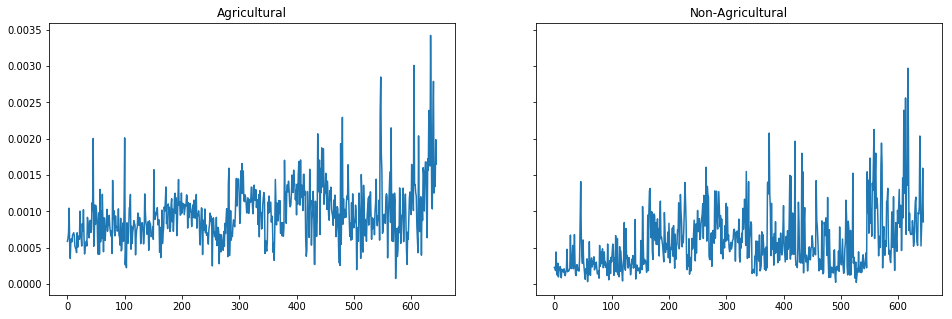

In [376]:
plotANA(wages)

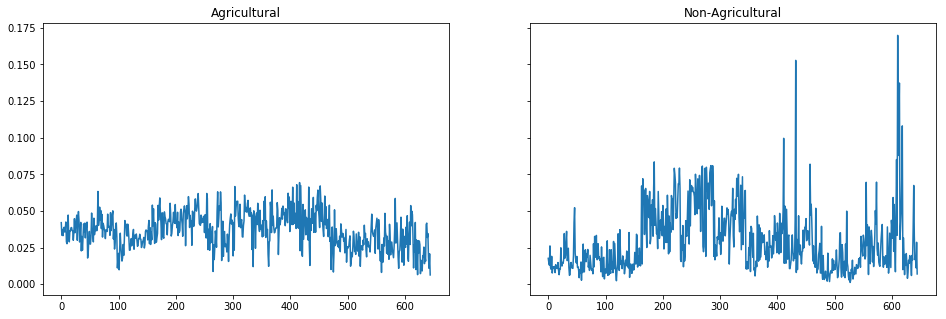

In [377]:
plotANA(newWages)

# Part 2: Space

In [378]:
def computeMovingProbs(wages):
    
    theta_h, theta_l = computeTheta(wages)
    Theta = np.expand_dims(np.vstack([theta_l, theta_h]), 0)
    expectedUtility = myGamma(param.zeta)*Theta
    
    constant = myGamma(param.eta/param.zeta)/param.eta * psi(param.r)**(param.eta-1)
    
    # since the interest rate is a constant, we can take psi(r_{t+1}) to be a constant too
    W_rt = constant * expectedUtility**param.eta + amenities[1] # amenities in 1910

    # tau is indexed like j x r
    stuff = np.expand_dims(W_rt, 2) - tau

    sums = np.sum(np.exp(1/param.kappa * stuff), axis=3) # across the R's, not the j's
    sums = np.expand_dims(sums, 3)

    movingProbs = np.exp(1/param.kappa * stuff)/sums
    return movingProbs


def newLocations(skills, wages):
    """
    updates the new locations
    """
    movingProbs = computeMovingProbs(wages)
    oldL = np.expand_dims(skills, axis=3)
    new = np.sum(movingProbs * oldL, axis=2)
    
    return new

newSkills = newLocations(skills, wages)
np.sum(newSkills, axis=R) # note that the overall lambda stays the same... since we didn't change that part

array([[0.7046579 , 0.29534209]])

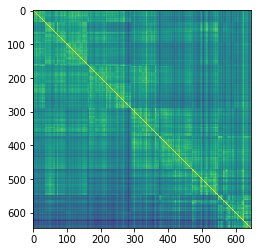

In [379]:
movingProbs = computeMovingProbs(newWages)
plt.imshow(movingProbs[t,H]**0.01)

L---- #0: 0.0003881930111046257
L---- #10: 2.0337506747141924e-05
L---- #20: 1.5119327471475286e-05
L---- #30: 1.2814469016745834e-05
L---- #40: 1.0556394500155e-05
L---- #50: 8.51472270611943e-06
L---- #60: 6.78231093461445e-06
L---- #70: 5.358918673539747e-06
L---- #80: 4.209470536492506e-06
L---- #90: 3.291485716305517e-06


Text(0,0.5,'log high-skill')

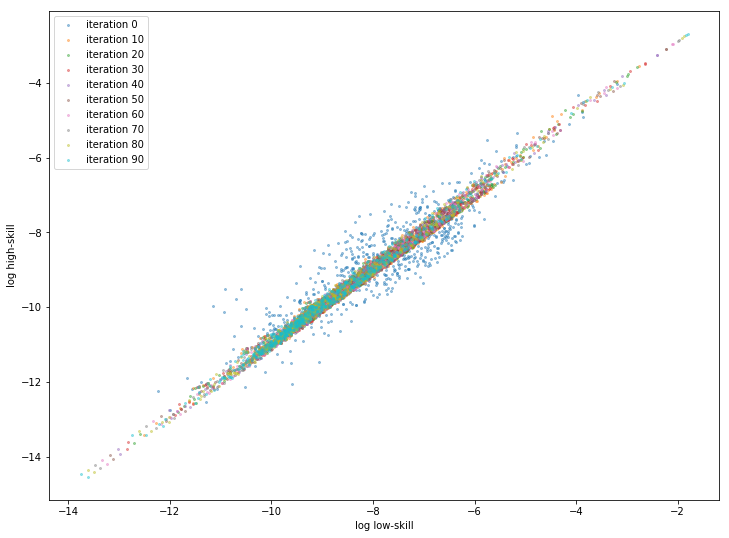

In [392]:
# init
wages  = readWages()
skills = readSkills()

plt.figure(figsize=(12,9))

lr = 0.94
losses = []
labels = []

# loop
for i in range(100):
    
    # find a fixed point wage, given location
    wages = loopy(skills, wages, log=False)
    
    # find the new locations, given the wage
    newSkills = newLocations(skills, wages)
    
    loss = np.sum((newSkills - skills)**2)
    losses.append(loss)
    
    skills = lr * newSkills + (1-lr)*skills
    
    if loss < 1e-7:
        print('L---- #{}: {}'.format(i, loss))
        break
    
    if i % 10 == 0:
        print('L---- #{}: {}'.format(i, loss))
        drawLog(skills)
        labels.append('iteration {}'.format(i))


plt.legend(labels)
plt.xlabel('log low-skill'); plt.ylabel('log high-skill')

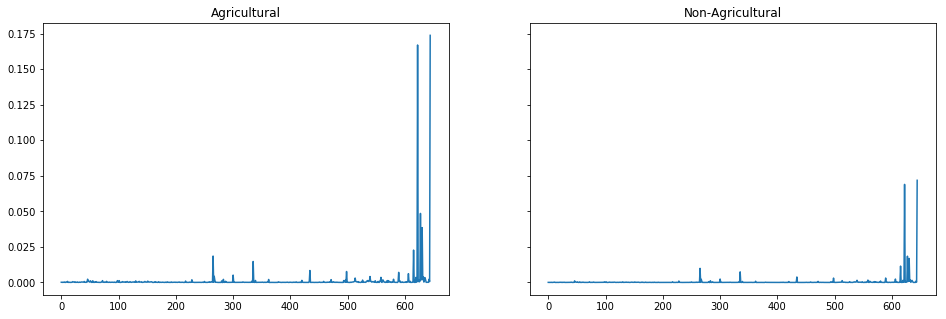

In [381]:
plotANA(skills)

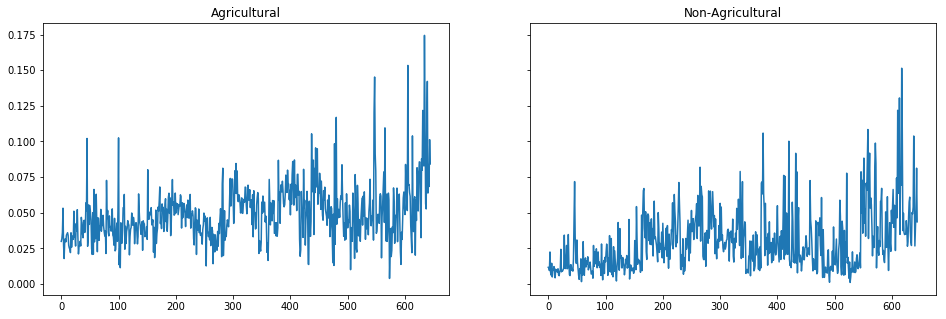

In [382]:
plotANA(priceNormalize(readWages())) # before

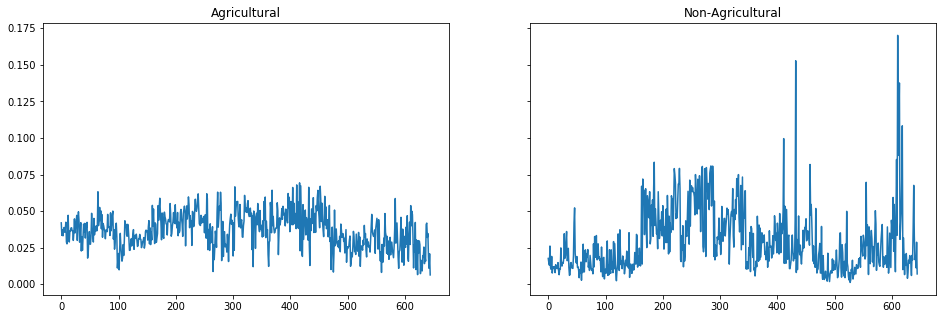

In [383]:
plotANA(wages) # after

BUT:

Given the locations, the new wages still change

w-- #0: 0.4054259796828976
w-- #10: 7.418349015843627e-08


5.35751344135247e-06

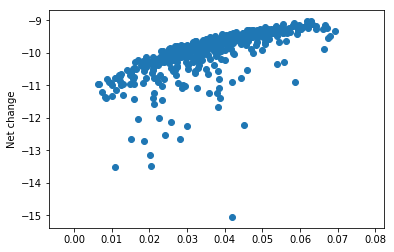

In [384]:
# find a fixed point wage, given location
newWages = loopy(skills, wages)

plt.scatter(wages[t,A], np.log(np.abs(newWages - wages)[t,A]))
plt.ylabel('Net change')

np.sum((newWages - wages)**2)

In [386]:
# the distribution of people is close to the same, though

newSkills = newLocations(skills, newWages)
np.sum((newSkills - skills)**2)

2.564246218903178e-06

Not converged yet?

## Are these the 1910 wages and locations?

since 
$$
K_{t+1} = (1-\psi(r_{t+1}) (1-\alpha) PY_t
$$

we have:

$$
R_1 K_1 = \alpha PY_1
$$

Or:
$$
R_1 (1-\psi(r_1))(1-\alpha) PY_0 = \alpha PY_1
$$

Thus:
$$
(r_1 + \delta) (1-\psi(r_1))  = \frac{\alpha PY_1}{(1-\alpha) PY_0}
$$


In [286]:
# 1880 wages and locations
oldSkills, oldWages = readSkills(), readWages()
GDP_0 = computeGDP(oldSkills, oldWages)

# 1910 wages and locations
GDP_1 = computeGDP(skills, wages)

# right hand side
const = param.alpha / (1-param.alpha) * (GDP_1 / GDP_0)
const

0.583801644077901

In [285]:
interest_rate = param.r/100

(interest_rate + param.delta) * (1-psi(interest_rate))

0.12332951091056227

Text(0,0.5,'log manufacturing earnings 1910')

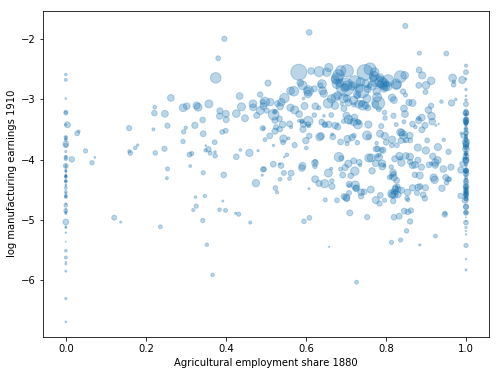

In [325]:
# Figure 3 in the paper
# agricultural employment share 1880 vs log Manufacturing earnings 1910

lamda, Lrt, lam_rt = computeLrt(oldSkills) # 1880
sizes = np.floor(Lrt[0]**0.6 * 2000)

plt.figure(figsize=(8,6))
plt.scatter(lam_rt[t,A], np.log(priceNormalize(wages)[t,NA]), alpha=0.3, s=sizes)
plt.xlabel('Agricultural employment share 1880')
plt.ylabel('log manufacturing earnings 1910')

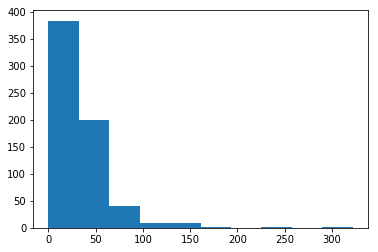

In [145]:
_ = plt.hist(sizes)

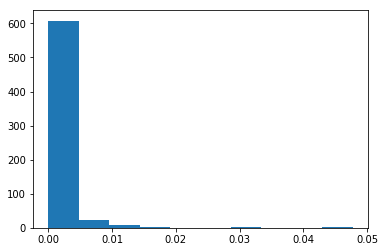

In [146]:
_ = plt.hist(Lrt[0])

doesn't look right to me!!